In [67]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from DTA.plotting import make_density_enrichment_heatmap, outline_site, plot_histogram, plot_titration_curve, make_custom_colormap
from DTA.utils import load_replica_counts, parse_tcl_dat_file, calculate_dG
from DTA.Site import Site
from DTA.SymmetricSite import SymmetricSite
from DTA.SiteAcrossReplicas import SiteAcrossReplicas

colormap = make_custom_colormap()

***

## EDIT THESE SETTINGS

In [40]:
root_path = Path("/home/js2746/ELIC5/simulations/PC_CL/5%CDL/") # The directory containing your replica subdirectories
DPPC_root_path = Path("/home/js2746/ELIC5/simulations/DPPC/") # The directory containing the outputs of PolarDensityBin from your DPPC + protein simulation
DPPC_bulk_root_path = Path("/home/js2746/ELIC5/simulations/DPPC_bulk/") # The directory that will contain the outputs of do_get_counts.tcl from your DPPC bulk simulation
system_names = ["CDL1", "POPC"] # The filestem that PolarDensityBin used. Must be a list.
leaflets = ['upp', 'low'] # Which leaflets should be included in analysis? Must be a list.
replicas = ["rep2", "rep3", "rep4", "rep5"] # names of replica subdirectories, located in the "root_path" directory
helix_definitions = root_path.joinpath(replicas[0]) #where are the coordinates for the transmembrane helices?
max_enrichment = 3 # how high do you want your heat map to go?
heatmap_height = 3 * len(system_names) # edit this if you want to change the size of your heatmap figure
heatmap_width = 3 * len(leaflets) # edit this if you want to change the size of your heatmap figure

***

## STEP A: MAKE A HEATMAP OF DENSITY ENRICHMENT
#### Step A0: Run PolarDensityBin on your simulation systems
#### Step A1: Make a heatmap of the outputs

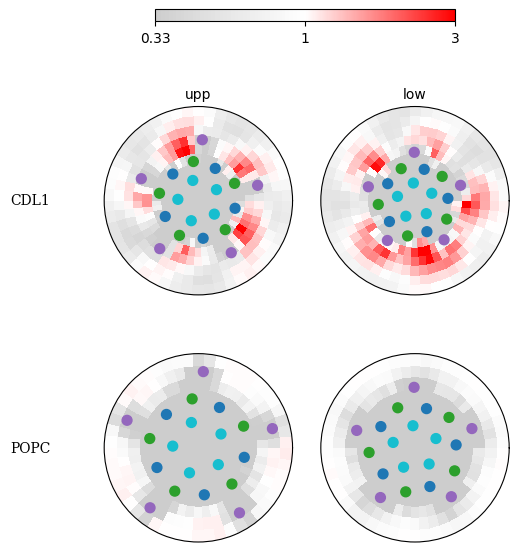

In [41]:
fig1, axes, grid_dims = make_density_enrichment_heatmap(system_names, colormap, max_enrichment, helix_definitions, (heatmap_height, heatmap_width), leaflets, root_path, replicas)
plt.savefig(root_path.joinpath("enrichments.pdf"), bbox_inches='tight')   

***

## STEP B: MAKE A SYMMETRIC SITE

#### Step B0: Select which system/species you want to analyze

In [42]:
system_name = "CDL1"  # should correspond to one of the axes labels printed above!

#### Step B1: Create a Site object.
Give it a name, specify the leaflet (1=outer, 2=inner), and the temperature (in K).

In [43]:
site1 = Site(name="inner M1-M4", leaflet_id=2, temperature=320) # step 1

#### Step B2: Add a list of bin coordinates
Bin tuples are (r, theta), numbered starting from the center mvoing out (r) and 3 o'clock moving counterclockwise (theta) \
We usually take a guess and then revise our guess based on what the outline looks like in step B4.

In [44]:
site1.bin_coords = [(5, 8), (5, 9), (6, 9), (6, 8), (6, 10)] # step 2

#### Step B3: Make a SymmetricSite object.
- Specify the symmetry. We chose five-fold because we simulated a pentamer.
- Give it your Site object as the base_site.
- Tell it how many theta bins are in your lattice.

In [45]:
symm_site1 = SymmetricSite(symmetry=5, base_site=site1, Ntheta=grid_dims.Ntheta) #step 3

#### Step B4: Outline the site on the heatmap with outline_site()
Each heatmap subplot has a different index. Make sure to choose the correct index. \
For example, if you wanted to measure the binding affinity of POPC in the inner leaflet, \
switch the axes index to '3'.

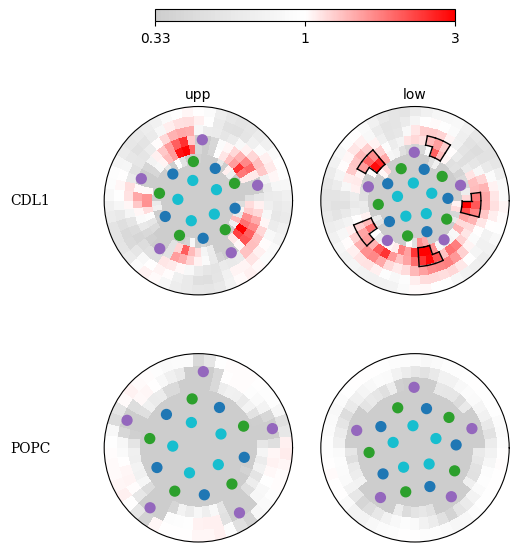

In [46]:
fig1, axes, grid_dims = make_density_enrichment_heatmap(system_names, colormap, max_enrichment, helix_definitions, (heatmap_height, heatmap_width), leaflets, root_path, replicas)

axes = outline_site(axes, symm_site1, grid_dims, 1) #step 4

plt.savefig(root_path.joinpath("enrichments_withSites.pdf"), bbox_inches='tight')

#### Step B5 (optional): If you don't like the placement of your site, go back to Step B2 

#### Step B6: Load all the counts outputs from PolarDensityBin from all your replicas 

In [47]:
replica_counts_list = load_replica_counts(root_path, replicas, system_name, site1.leaflet_id)

#### Step B7: Create a SiteAcrossReplicas object to store all this data

In [48]:
symm_site_across_replicas_1 = SiteAcrossReplicas(replica_counts_list, base_site=symm_site1)

***

## Step C: Find accessible area of site

#### Step C0: Run PolarDensityBin on your 100% DPPC + Protein system 
Use the same settings that you used for the original system.

#### Step C1: Load the outputs and create a duplicate Site and SymmetricSite to hold your DPPC data

In [49]:
# load the outputs
DPPC_outer = DPPC_root_path.joinpath(f"DPPC.upp.dat")
DPPC_outer_counts, grid_dims, outer_system_info = parse_tcl_dat_file(DPPC_outer, bulk=False)
DPPC_inner = DPPC_root_path.joinpath(f"DPPC.low.dat")
DPPC_inner_counts, grid_dims, inner_system_info = parse_tcl_dat_file(DPPC_inner, bulk=False)

In [50]:
# create a duplicate Site and SymmetricSite
DPPC_site1 = Site(name=f"{site1.name}_DPPC", leaflet_id=site1.leaflet_id, temperature=site1.temperature)
DPPC_site1.bin_coords = site1.bin_coords
DPPC_symm_site1 = SymmetricSite(symmetry=symm_site1.symmetry, base_site=DPPC_site1, Ntheta=symm_site1._Ntheta)

#### Step C2: add the DPPC counts from the correct leaflet
If you made your original site in the outer leaflet, use DPPC_outer_counts!

In [51]:
DPPC_symm_site1.update_counts_histogram(bulk=False, counts_data=DPPC_inner_counts)

#### Step C3a: Calculate the geometric area of the site

In [52]:
site1_geom_area = round(DPPC_site1.calculate_geometric_area(grid_dims.dr, grid_dims.dtheta))
print(f"Initial guess for accessible area is geometric area: {site1_geom_area} A^2")

Initial guess for accessible area is geometric area: 96 A^2


#### Step C3b: Plot the histogram of DPPC beads in your site

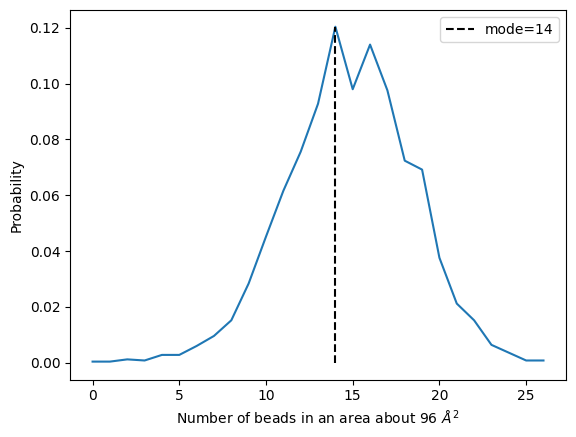

In [53]:
fig,ax = plt.subplots()
ax = plot_histogram(ax, DPPC_symm_site1.site_counts_histogram, site1_geom_area, plot_probability=True)
plt.show()
plt.clf()
plt.close()

#### Step C4a: Edit density_threshold_affinity/accessible_area/do_get_counts.tcl to run on your DPPC bulk system with the area of your site, 
#### provided in step C3a
#### Step C4b: Load your bulk DPPC simulation (no protein) in VMD and source do_get_counts.tcl

#### Step C5: Load the bulk counts into this notebook

In [54]:
DPPC_bulk_counts, _, _ = parse_tcl_dat_file(DPPC_bulk_root_path.joinpath(f"DPPC_counts_{site1_geom_area}.out"), bulk=True) #step C5

#### Step C6: Update the bulk counts of DPPC_symm_site1

In [55]:
DPPC_symm_site1.update_counts_histogram(True, DPPC_bulk_counts) #step C6

#### Step C7: Plot the distribution

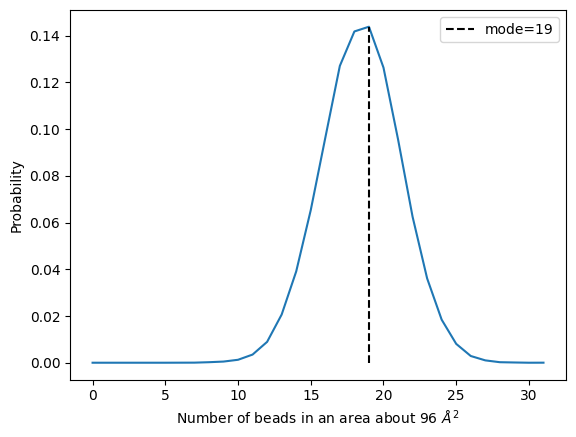

In [56]:
fig,ax = plt.subplots()
ax = plot_histogram(ax, DPPC_symm_site1.bulk_counts_histogram, f"{site1_geom_area}", plot_probability=True) #step C7
plt.show()
plt.clf()
plt.close()

#### Step C8: Predict a better guess for the true accessible area of the site

In [57]:
better_guess = round(DPPC_symm_site1.predict_accessible_area(site1_geom_area))
print(f"Rerun do_get_counts.tcl but use this for the area instead: {better_guess} A^2")

Rerun do_get_counts.tcl but use this for the area instead: 71 A^2


#### Step C9a: Rerun do_get_counts.tcl with the better estimate provided above

#### Step C9b: Plot the new distribution

In [58]:
DPPC_bulk_counts, _, _ = parse_tcl_dat_file(DPPC_bulk_root_path.joinpath(f"DPPC_counts_{better_guess}.out"), bulk=True)
DPPC_symm_site1.update_counts_histogram(True, DPPC_bulk_counts)
fig,ax = plt.subplots()
ax = plot_histogram(ax, DPPC_symm_site1.bulk_counts_histogram, f"{better_guess}", plot_probability=True)
plt.show()
plt.clf()
plt.close()

AssertionError: Could not find /home/js2746/ELIC5/simulations/DPPC_bulk/DPPC_counts_71.out

#### Step C9c: Does the mode from C9b match the mode from C3b?
#### If yes, congratulations! You have identified the accessible area of your site. 
#### If no, try running do_get_counts with a smaller area.
#### Repeat step C9b, but replace "better_guess" with the smaller area you tried.
#### Step C9d: Enter your final "accessible area" number below.

In [60]:
accessible_area = 81

***

## Step D: Calculate your Density-Threshold Affinity

#### Step D0: Run do_get_counts.tcl on your bulk simulation
Modify do_get_counts.tcl to apply to your non-DPPC bulk simulation and use the accessible area from step C9c.\
Open VMD, load your bulk trajectory, and source do_get_counts.tcl.

#### Step D1: Specify the path to the outputs from step D0

In [61]:
bulk_counts_path = root_path.joinpath("bulk", f"{system_name}_counts_{accessible_area}.out")

#### Step D2: Load the bulk counts

In [62]:
bulk_counts_list, _, _ = parse_tcl_dat_file(bulk_counts_path, bulk=True)

#### Step D3: Add the bulk counts to your SiteAcrossReplicas object

In [64]:
symm_site_across_replicas_1.update_counts_histogram(bulk=True, counts_data=bulk_counts_list)

#### Step D4: Plot the bulk distribution

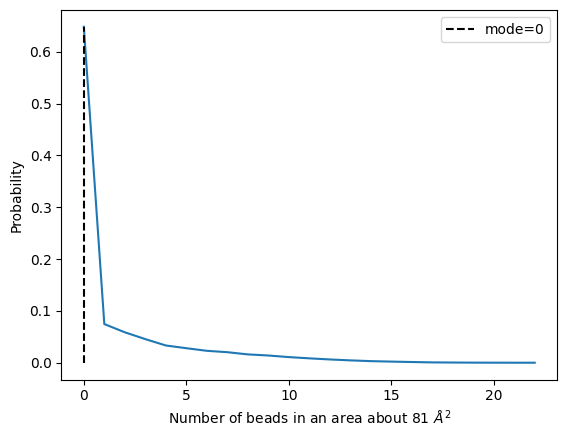

In [65]:
fig, ax = plt.subplots()
ax = plot_histogram(ax, symm_site_across_replicas_1.bulk_counts_histogram, accessible_area, plot_probability=True)
plt.show()
plt.clf()
plt.close()

### Step E: Calculate your density-threshold affinity!

#### Step E1: Calculate the raw numbers

In [68]:
dgSite = float(calculate_dG(symm_site_across_replicas_1.site_counts_histogram, symm_site_across_replicas_1.n_peak, site1.temperature))
dgRef = float(calculate_dG(symm_site_across_replicas_1.bulk_counts_histogram, symm_site_across_replicas_1.n_peak, site1.temperature))

print(f"dGcalc ={dgSite} kcal/mol")
print(f"dGref ={dgRef} kcal/mol")
print(f"Overall binding affinity dG is {symm_site_across_replicas_1.dG} kcal/mol")
print(f"st.dev is plus or minus {symm_site_across_replicas_1.dG_std} kcal/mol")

dGcalc =-0.012464144139216067 kcal/mol
dGref =0.38939144113077534 kcal/mol
Overall binding affinity dG is -0.40185558526999143 kcal/mol
st.dev is plus or minus 0.08099535021244138 kcal/mol


#### Step E2: Plot a titration curve

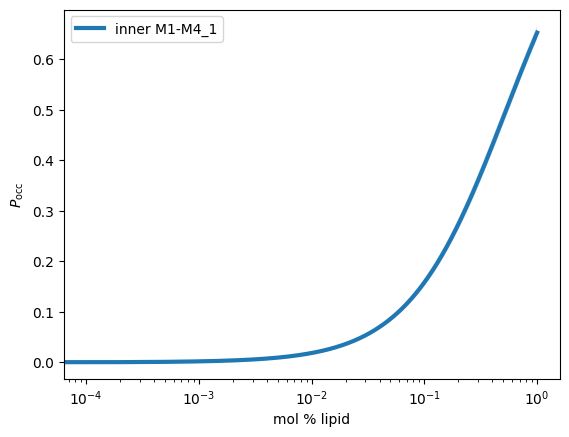

In [70]:
fig, ax = plt.subplots()
ax = plot_titration_curve(ax, symm_site_across_replicas_1.dG, symm_site_across_replicas_1.dG_std, site1.temperature, site1.name, True, 'CI', symm_site1.symmetry * len(replicas))
ax.set_xscale('log')
ax.legend()
ax.set_xlabel('mol % lipid')
ax.set_ylabel(r'$P_{\mathrm{occ}}$')
plt.show()
plt.clf()
plt.close()